In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import ground_motion_qh
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
import os
from pathlib import Path
from pprint import pprint
import pickle

base_dir = Path(ground_motion_qh.__file__).parent.parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
# ADD YOUR PICKS HERE:
pick_fn='/home/yiwasak2/QuakeHack/GroundMotion_QH/All_magnitude.csv'
pick_df=pd.read_csv(pick_fn, index_col=0)
#pick_df=pick_df[(pick_df['mag']>=3.0)]
for index,row in pick_df.iterrows():
    pick_df.loc[index,'time']=UTCDateTime(row['time'])

pick_times = pick_df['time'].values #...or whatever as a numpy datetime array
print(pick_df)

       id                         time  pstime       mag
96     86  2009-03-21T11:24:47.177143Z    4.85  3.411548
136   126  2009-04-09T21:45:32.234286Z    5.50  3.248202
143   133  2009-04-16T17:55:32.205714Z    4.86  3.572823
275   265  2009-06-19T15:30:37.777143Z    4.01  3.615122
590     7  2010-01-11T23:33:53.612857Z    6.77  3.145073
...   ...                          ...     ...       ...
7638  594  2019-11-20T06:42:23.652857Z    2.57  3.473032
7737   58  2020-02-02T00:59:50.522857Z    3.27  4.035961
7802  123  2020-04-05T22:37:19.127143Z    2.61  3.584312
7847  168  2020-04-08T01:00:14.308571Z    2.39  3.167664
8039  360  2020-07-07T02:34:02.328571Z    4.63  3.569379

[93 rows x 4 columns]


In [35]:
download_name = "ANZA_SND_1994_M3_Picks"

# check if the folder already exists in the raw data folder
data_dir = base_dir / "data" / "raw_data" / download_name
if data_dir.exists():
    print(f"Folder {download_name} already exists in the raw data folder.")

# MAKE SURE TO CHANGE STATION LOCATION ALONG WITH THE STATION NAME!
station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
    latitude = 33.5519,
    longitude = -116.6129,
    start_time = '1982-10-01',
    number_of_tries = 2,
)

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

analysis_metadata = dict(
    mid_buffer = 20,
    forecast_time_window = 60*60,
    event_time_window = 30,
    shift_times = False,
)

analysis_metadata["pre_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
analysis_metadata["post_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]


Folder ANZA_SND_1994_M3_Picks already exists in the raw data folder.


In [36]:
pprint(analysis_metadata, width=1)

{'event_time_window': 30,
 'forecast_time_window': 3600,
 'mid_buffer': 20,
 'post_buffer': 590.0000000000001,
 'pre_buffer': 590.0000000000001,
 'shift_times': False}


In [37]:
metadata = dict(
    analysis_metadata = analysis_metadata,
    station_metadata = station_metadata,
)

# create a data directory with and save the metadata
data_dir = base_dir / "data" / "raw_data" / download_name
os.makedirs(data_dir, exist_ok=True)
np.save(data_dir / "metadata.npy", metadata)

In [38]:
minus_time_range = [
    analysis_metadata["pre_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
]

plus_time_range = [
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]+ analysis_metadata["mid_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"] +analysis_metadata["forecast_time_window"]
]

In [39]:
print(pick_times.size)
print(pick_times)

93
[UTCDateTime(2009, 3, 21, 11, 24, 47, 177143)
 UTCDateTime(2009, 4, 9, 21, 45, 32, 234286)
 UTCDateTime(2009, 4, 16, 17, 55, 32, 205714)
 UTCDateTime(2009, 6, 19, 15, 30, 37, 777143)
 UTCDateTime(2010, 1, 11, 23, 33, 53, 612857)
 UTCDateTime(2010, 6, 3, 8, 44, 13, 720000)
 UTCDateTime(2010, 6, 8, 8, 58, 21, 140000)
 UTCDateTime(2010, 6, 15, 16, 23, 45, 134286)
 UTCDateTime(2010, 6, 16, 13, 46, 30, 480000)
 UTCDateTime(2010, 6, 18, 15, 14, 40, 310000)
 UTCDateTime(2010, 7, 8, 2, 34, 36, 131429)
 UTCDateTime(2010, 7, 8, 16, 22, 51, 265714)
 UTCDateTime(2010, 7, 12, 5, 50, 29, 418571)
 UTCDateTime(2010, 8, 6, 17, 39, 32, 955714)
 UTCDateTime(2010, 8, 11, 20, 47, 20, 881429)
 UTCDateTime(2010, 10, 6, 17, 58, 8, 294286)
 UTCDateTime(2010, 11, 19, 0, 56, 55, 498571)
 UTCDateTime(2010, 12, 23, 3, 39, 36, 515714)
 UTCDateTime(2011, 2, 12, 17, 30, 44, 331429)
 UTCDateTime(2011, 3, 29, 10, 43, 26, 104286)
 UTCDateTime(2011, 6, 3, 5, 45, 24, 190000)
 UTCDateTime(2011, 6, 14, 8, 25, 41, 91429)


In [ ]:
a_max_minus = []
a_max_plus = []

#while i<pick_times.size:
for i, t1 in enumerate(pick_times):
    print(f"Dowloading event {i}: {t1}")
    
    """ t2 = np.datetime64(t1) + np.timedelta64(
        int(  # (QUAKE) HACK
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        ),"s",
    ) """
    t1 = t1 - analysis_metadata["pre_buffer"]
    t2 = t1 + int(  # (QUAKE) HACK
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        )
    

    # preprocess the waveforms
    i = 0
    while i < station_metadata["number_of_tries"]:
        try:
            stream_dict = get_stream_multiple_stations(
                t1=UTCDateTime(t1),
                t2=UTCDateTime(t2),
            )
            tmp_stream=stream_dict['SND']
            tmp_stream
            #stream_dict['SND'].plot()
            event_dir = data_dir / f"data/{t1.strftime('%Y-%m-%d_%H-%M-%S')}"

            os.makedirs(event_dir, exist_ok=True)

            with open(event_dir / "stream_dict.pkl", "wb") as f:
                pickle.dump(stream_dict, f)

            amplitude, times = raw_stream_to_amplitude_and_times(stream_dict["SND"])
            np.save(event_dir / "amplitude.npy", amplitude)
            np.save(event_dir / "times.npy", times)

            minus_time_range = [
                analysis_metadata["pre_buffer"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"],
            ]

            plus_time_range = [
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"]
                + analysis_metadata["mid_buffer"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"]
                + analysis_metadata["mid_buffer"]
                + analysis_metadata["forecast_time_window"],
            ]

            a_minus = amplitude[
                (times >= minus_time_range[0]) & (times <= minus_time_range[1])
            ]
            a_plus = amplitude[
                (times >= plus_time_range[0]) & (times <= plus_time_range[1])
            ]

            a_max_minus.append(
                np.max(a_minus)
            )  # note that the instrument response is removed, then we detrend, and hi
            a_max_plus.append(np.max(a_plus))

        except Exception as e:
            print(f"Error dowloading event {i}: {e}")

        i += 1

Dowloading event 0: 2009-03-21T11:24:47.177143Z


Dowloading event 1: 2009-04-09T21:45:32.234286Z


In [ ]:
np.save(data_dir / "a_max_minus.npy", np.array(a_max_minus))
np.save(data_dir / "a_max_plus.npy", np.array(a_max_plus))

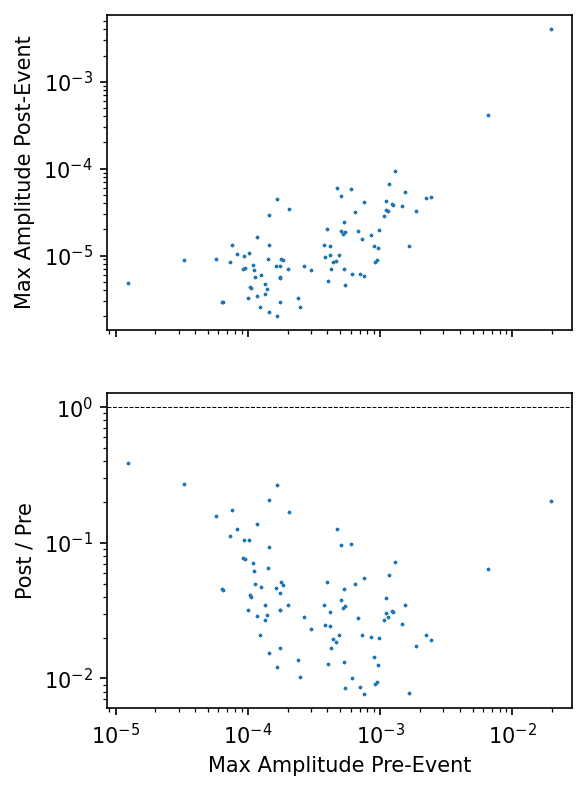

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4, 6), dpi=150)
ax[0].scatter(np.array(a_max_minus), np.array(a_max_plus), s=0.5)
ax[0].set(
    xscale="log", 
    yscale="log",
    ylabel="Max Amplitude Post-Event",
)

ax[1].scatter(np.array(a_max_minus), np.array(a_max_plus)/np.array(a_max_minus), s=0.5)
ax[1].set(
    xscale="log", 
    yscale="log",
    xlabel="Max Amplitude Pre-Event",
    ylabel="Post / Pre",
)
ax[1].axhline(1, color="k", linestyle="--", lw=0.5)



In [ ]:
# This goes in analysis file

# for each file in REPO 

# load stream

# split into parts

# calculate shaking intensity (e.g. PGV)